In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
df = pd.read_csv('data/covid_19_data.csv')

In [2]:
# I referred code regarding data preprocessing from https://www.kaggle.com/chirag9073/coronavirus-covid-19-outbreak-data-analysis

df.drop(['SNo'], axis=1, inplace=True)
df['ObservationDate'] = df['ObservationDate'].apply(pd.to_datetime)

In [3]:
df.head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,2020-01-22,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,2020-01-22,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,2020-01-22,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,2020-01-22,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,2020-01-22,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [4]:
df.isnull().sum()

ObservationDate      0
Province/State     800
Country/Region       0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [5]:
df[df['Province/State'].isnull()].head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
35,2020-01-22,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0
36,2020-01-22,NaN,Thailand,1/22/2020 17:00,2.0,0.0,0.0
37,2020-01-22,NaN,South Korea,1/22/2020 17:00,1.0,0.0,0.0
73,2020-01-23,NaN,Japan,1/23/20 17:00,1.0,0.0,0.0
74,2020-01-23,NaN,Thailand,1/23/20 17:00,3.0,0.0,0.0
75,2020-01-23,NaN,South Korea,1/23/20 17:00,1.0,0.0,0.0
76,2020-01-23,NaN,Singapore,1/23/20 17:00,1.0,0.0,0.0
77,2020-01-23,NaN,Philippines,1/23/20 17:00,0.0,0.0,0.0
78,2020-01-23,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
79,2020-01-23,NaN,Vietnam,1/23/20 17:00,2.0,0.0,0.0


In [6]:
# Current situation
grouped_df = df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered'].max()
grouped_df.style.background_gradient(cmap='Pastel1_r')

In [7]:
# Top 10 Countries with most no. of reported cases
latest_df = df[df['ObservationDate'] == max(df['ObservationDate'])].reset_index()
grouped_df = latest_df.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

temp = grouped_df[['Country/Region', 'Confirmed']]
temp = temp.sort_values(by='Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.head(10).style.background_gradient(cmap='Pastel1_r')

,Country/Region,Confirmed
0,Mainland China,78824
1,South Korea,2337
2,Italy,888
3,Others,705
4,Iran,388
5,Japan,228
6,Hong Kong,94
7,Singapore,93
8,US,62
9,France,57


In [8]:
# Countries with all the cases recovered
temp = grouped_df[grouped_df['Confirmed']==grouped_df['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Recovered
0,Vietnam,16,16
1,India,3,3
2,Russia,2,2
3,Belgium,1,1
4,Cambodia,1,1
5,Egypt,1,1
6,Nepal,1,1
7,Sri Lanka,1,1


In [9]:
# Most recent stats
daily_df = df.groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
daily_df = daily_df.reset_index()
daily_df = daily_df.sort_values('ObservationDate', ascending=False)
daily_df.head(1).style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
37,2020-02-28 00:00:00,84124,2867,36711


In [10]:
daily_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
37,2020-02-28 00:00:00,84124,2867,36711
36,2020-02-27 00:00:00,82756,2814,33277
35,2020-02-26 00:00:00,81397,2770,30384
34,2020-02-25 00:00:00,80415,2708,27905
33,2020-02-24 00:00:00,79570,2629,25227
32,2020-02-23 00:00:00,78985,2469,23394
31,2020-02-22 00:00:00,78599,2458,22886
30,2020-02-21 00:00:00,76843,2251,18890
29,2020-02-20 00:00:00,76199,2247,18177
28,2020-02-19 00:00:00,75641,2122,16121


In [11]:
daily_df.isnull().sum()

ObservationDate    0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [12]:
WINDOW_SIZE = 8

def seq2dataset(sr, window_size):
        seq_data = []
        for i in range(len(sr) - window_size):
            subset = list(sr[i:(i+window_size+1)])
            subset.reverse()
            seq_data.append(subset)
        seq_data.reverse()
        seq_data = np.array(seq_data)    
        return seq_data[:, 0:window_size], seq_data[:,window_size]

In [13]:
import datetime
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint


class PandemicRegressor():
    def __init__(self, window_size, batch_size):
        self.window_size = window_size
        self.batch_size = batch_size
        save_dir = os.path.join(os.path.join(os.getcwd(), 'model'), 
                                datetime.datetime.now().strftime('%Y-%m-%d;%H.%M.%S'))
        os.mkdir(save_dir)
        self.model_path = os.path.join(save_dir, 'pdm_reg.h5')
        self.callbacks = [
			EarlyStopping(monitor='val_loss', patience=20)
		]
        self.reg = self.build_model()
    def __del__(self):
        self.reg.save(self.model_path)
        print('saved in ' + self.model_path)
        
    def build_model(self):
        model = Sequential([
            #LSTM(64, input_shape=(self.window_size, 1), dropout=0.5, recurrent_dropout=0.5),
            LSTM(64, batch_input_shape=(self.batch_size, self.window_size, 1), dropout=0.5, stateful=True),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='linear')
        ])
        model.compile(loss='mean_squared_error', 
                      optimizer='rmsprop',
                      metrics=['mae', 'mape'])
        return model
    
    def fit(self, X_train, y_train, X_val, y_val, epochs=500):
        hist = self.reg.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=self.batch_size,
                            validation_data=(X_val, y_val),
                            callbacks=self.callbacks,
                            verbose=0,
                           shuffle=False)
        return hist
    
    def evaluate(self, X_test, y_test):
        loss_and_metrics = self.reg.evaluate(X_test, 
                                             y_test, 
                                             batch_size=self.batch_size)
        return loss_and_metrics
    
    def save(self):
        self.reg.save(self.model_path)
        print('saved in ' + self.model_path)
        
pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, batch_size=1)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


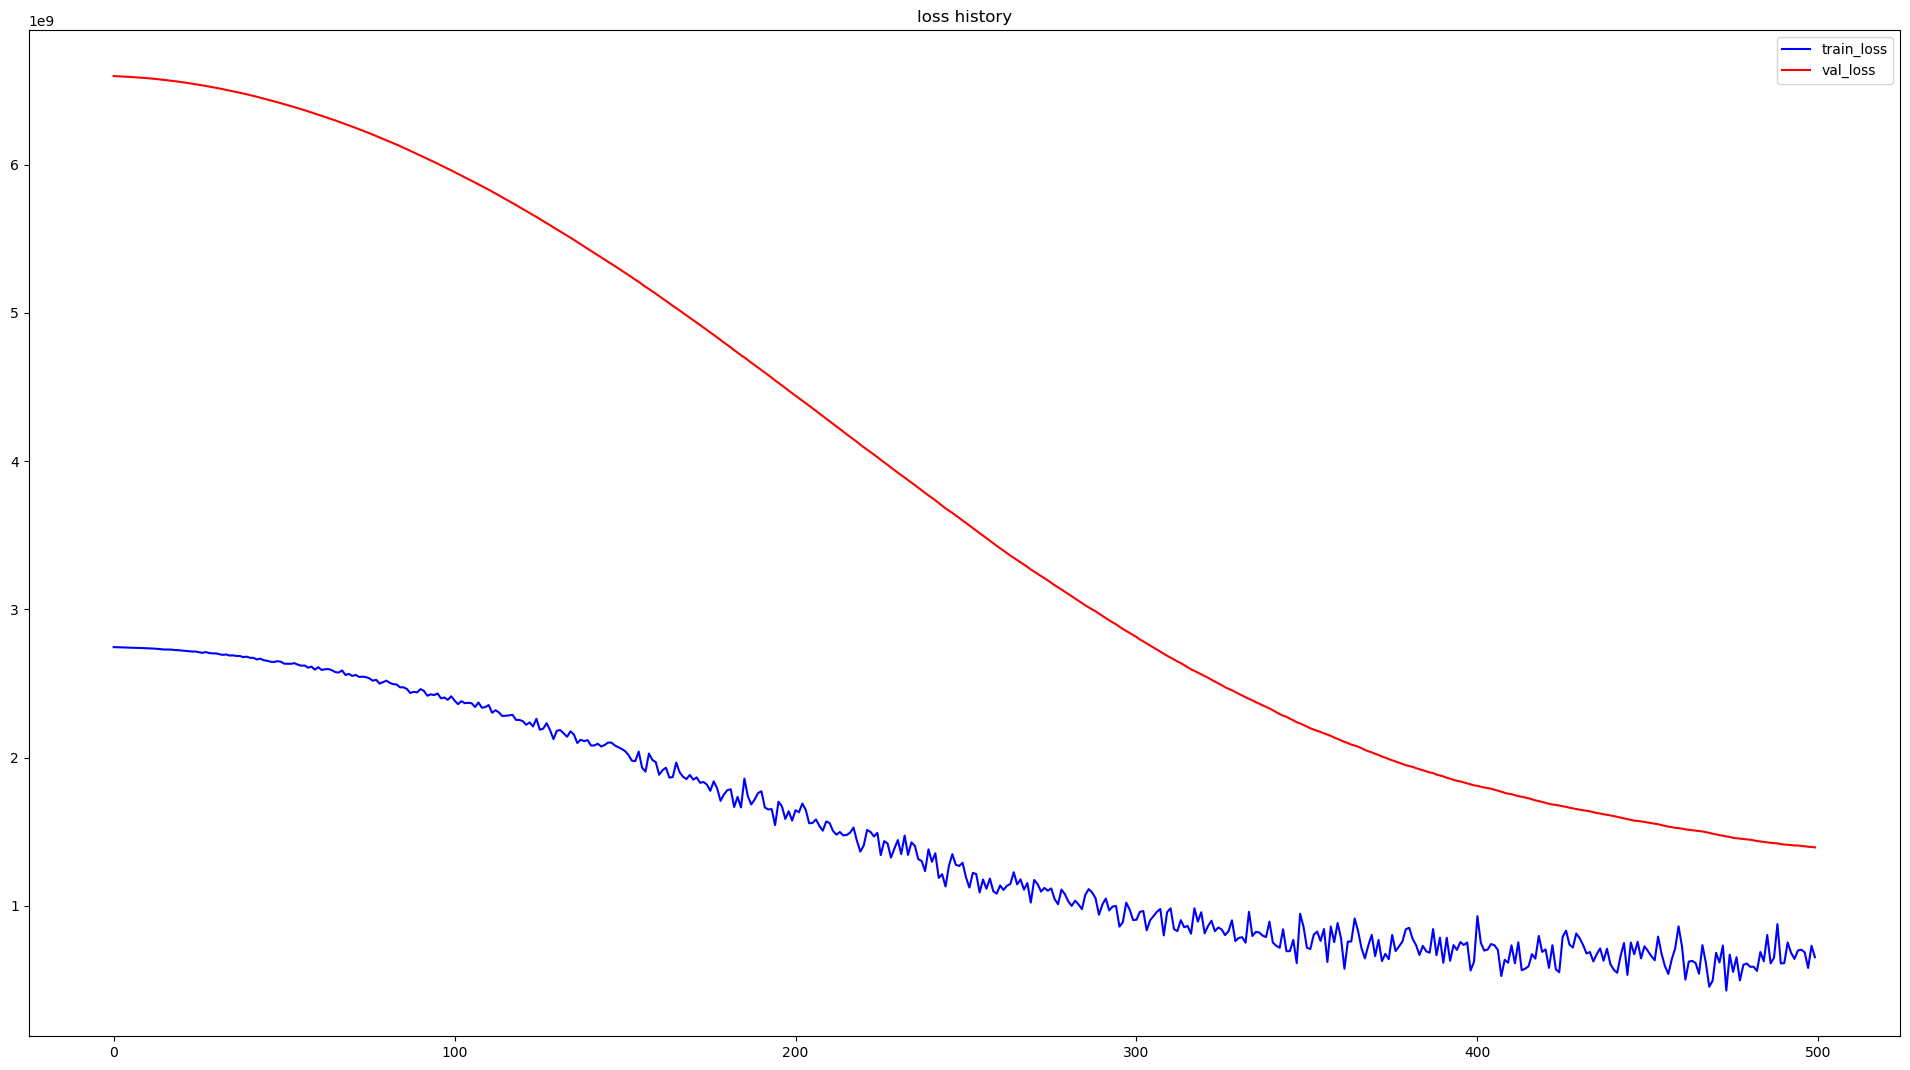

6/6 [==============================] - 0s 6ms/step
MAE: 37309.91015625, MAPE: 45.91770553588867


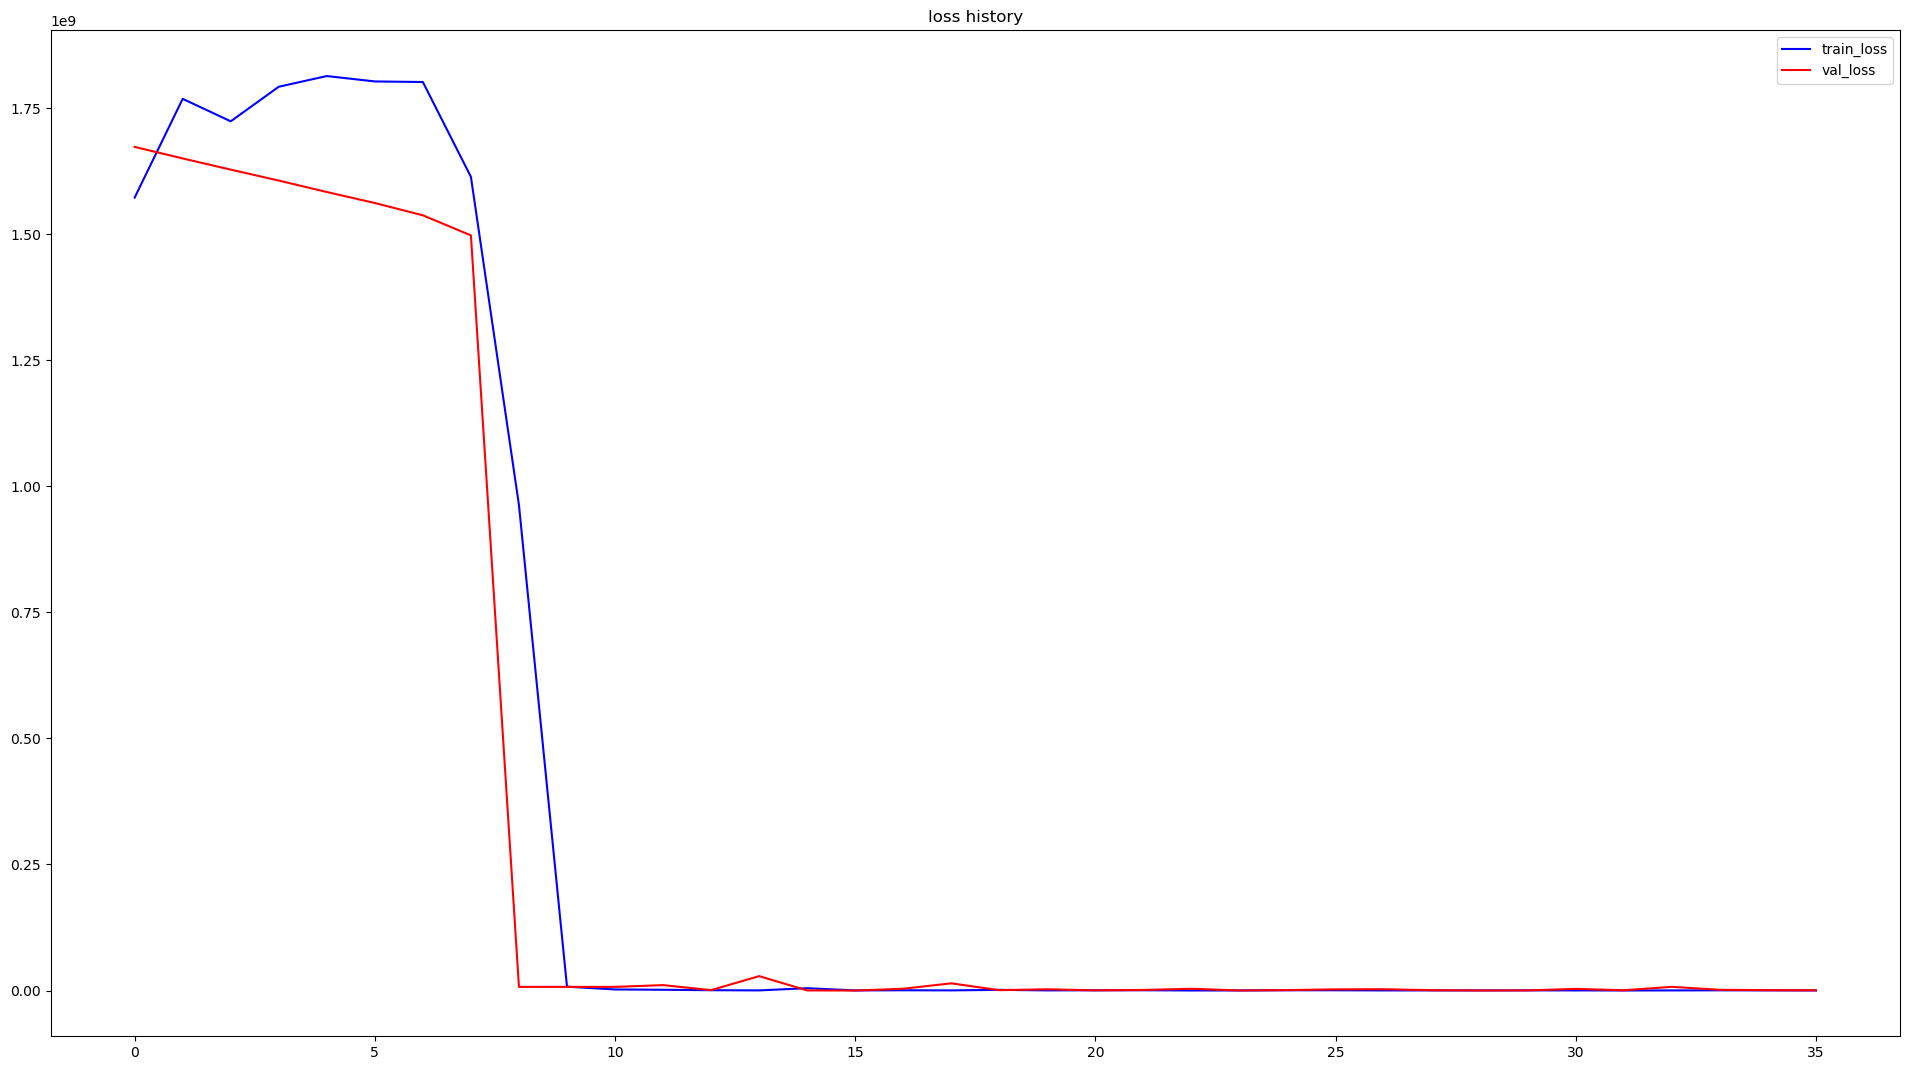

6/6 [==============================] - 0s 6ms/step
MAE: 757.4113159179688, MAPE: 27.822546005249023


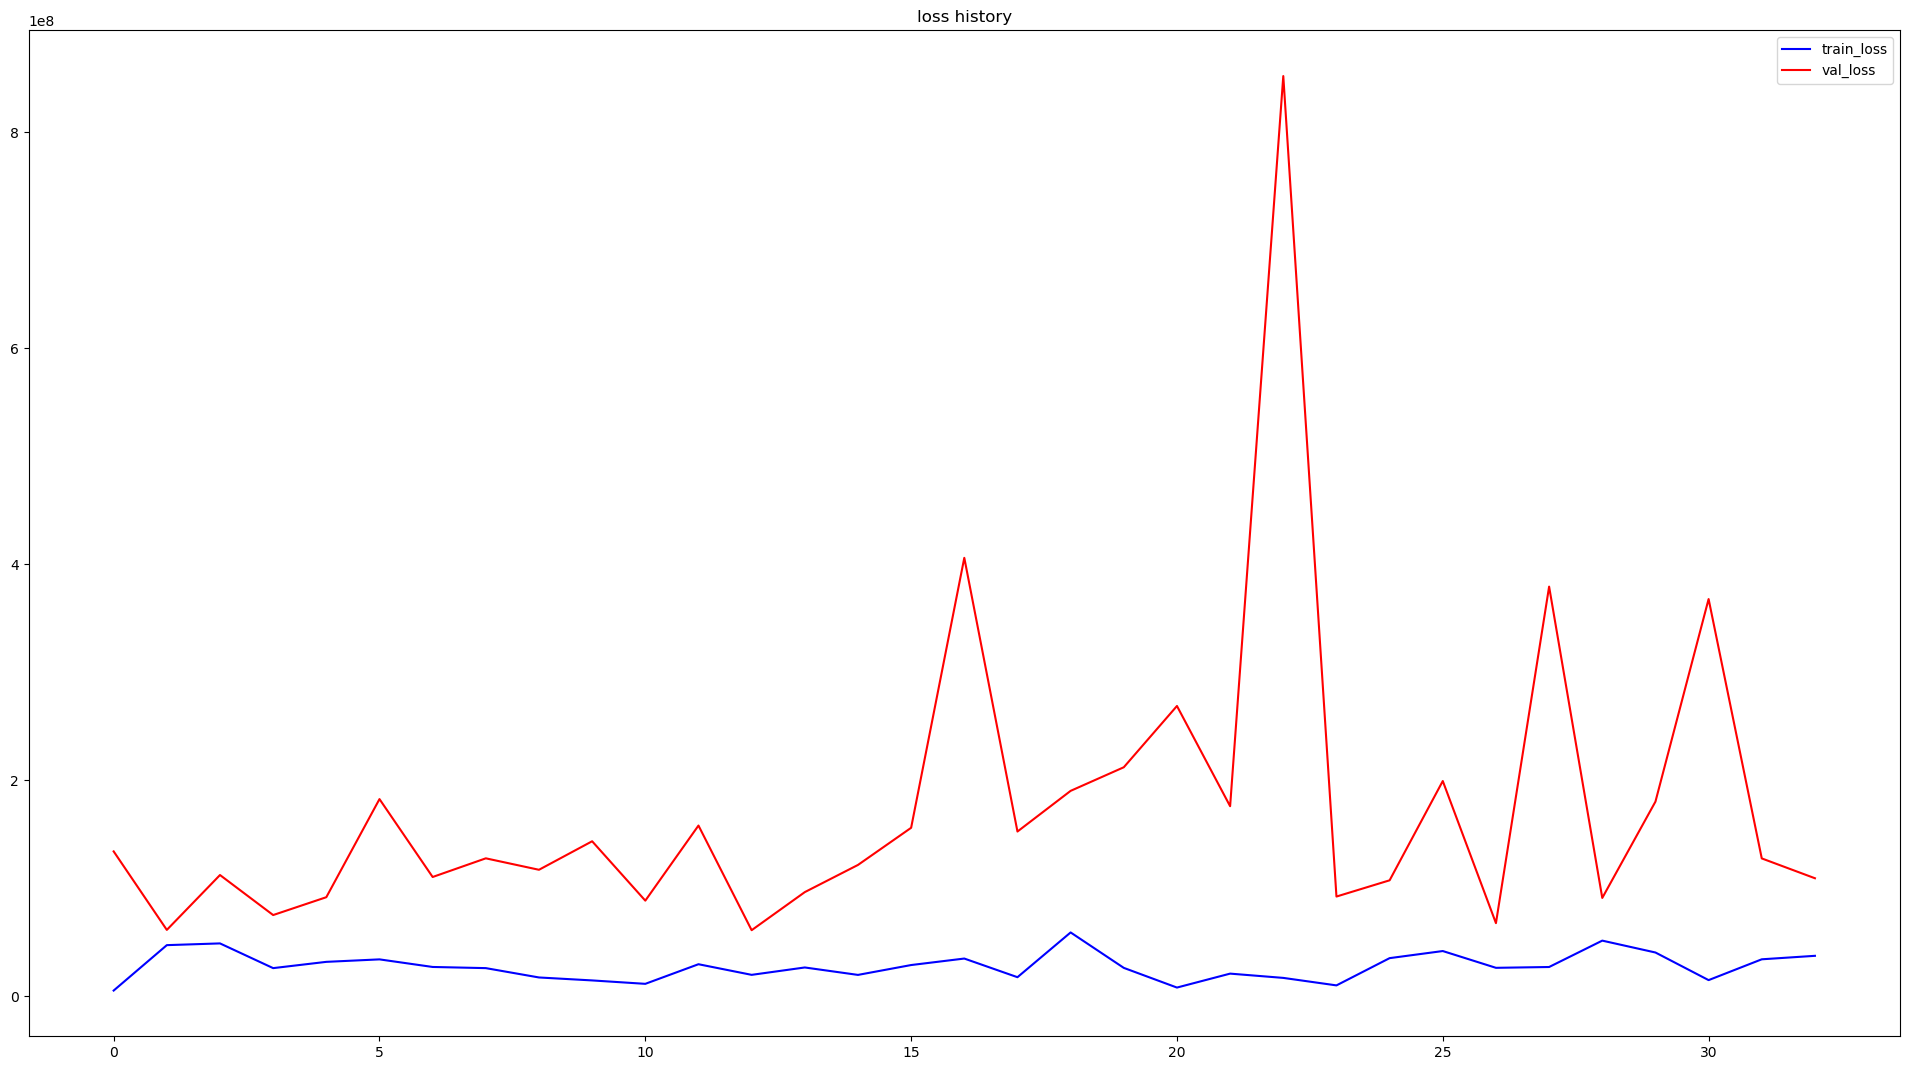

6/6 [==============================] - 0s 6ms/step
MAE: 28336.630859375, MAPE: 95.18025970458984
Train is done..


In [14]:
"""
Predict the global spread of coronavirus
"""
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def show_train_hist(hist):
    plt.figure(figsize=(19.2,10.8), dpi=100)
    plt.plot(hist.history['loss'], 'b-', label='train_loss')
    plt.plot(hist.history['val_loss'], 'r', label='val_loss')
    plt.title("loss history")
    plt.legend()
    plt.tight_layout()
    plt.show()

for col_name in ['Confirmed', 'Deaths', 'Recovered']:
    X, y = seq2dataset(daily_df[col_name], WINDOW_SIZE)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Normalize
    _mean = np.mean(daily_df[col_name].values)
    _std = np.std(daily_df[col_name].values)
    X_scaled_train = (X_train - _mean) / _std
    X_scaled_test = (X_test - _mean) / _std

    X_scaled_train = np.reshape(X_scaled_train, (len(X_scaled_train), WINDOW_SIZE, 1))
    X_scaled_test = np.reshape(X_scaled_test, (len(X_scaled_test), WINDOW_SIZE, 1))
    hist = pdm_reg.fit(X_train=X_scaled_train, 
                       y_train=y_train, 
                       X_val=X_scaled_test, 
                       y_val=y_test,
                       epochs=500)
    show_train_hist(hist)
    loss_and_metrics = pdm_reg.evaluate(X_test=X_scaled_test, 
                     y_test=y_test)
    print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')

print('Train is done..')